# Support Vector Machines

At the end of this exercise you will know:
- How to train a SVM using Sequential Minimal Optimization (SMO)
- How to train a SVM using Gradient Descent (GD)
- How different SVM Kernels perform

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.datasets import make_blobs

**Summary of the mathematical formalism**

Soft Margin SVM Lagrangian:

$$
\mathcal{L}(\omega, b, \xi, \alpha, \mu)=\frac{1}{2} \omega^{T} \omega+C \sum_{i=1}^{m} \xi_{i} -\sum_{i=1}^{m} \alpha_{i}\left[y^{(i)}\left(\omega^{\top} x^{(i)}+b\right)-1+\xi_{i}\right]-\sum_{i=1}^{m} \mu_{i} \xi_{i}.
$$

Primal problem:

$$
\min _{\omega, b} \left( \frac{1}{2}\|\omega\|^{2}+C \sum_{i=1}^{m} \xi_{i}\right)
$$

$$
\text{s.t.}\left\{\begin{array}{l}y^{(i)}\left(\omega^{\top} x^{(i)}+b\right) \geq 1-\xi_{i}, \quad i=1, \ldots, m \\ \xi_{i} \ge 0, \quad i=1, \ldots, \mathrm{m}\end{array}\right.
$$

Dual problem:

$$
\max_{\alpha} \left( \sum_{i=1}^{m} \alpha_{i}-\frac{1}{2} \sum_{i,j=1}^{m} y^{(i)} y^{(j)} \alpha_{i} \alpha_{j} K(x^{(i)}, x^{(j)}) \right)
$$

$$
\text { s.t. }\left\{\begin{array}{l}
0 \leq \alpha_{i} \leq C, \quad i=1, \ldots, m \\
\sum_{i=1}^{m} \alpha_{i} y^{(i)}=0
\end{array}\right.
$$

In the dual problem, we have used that $w=\sum_{i=1}^{m} \alpha_{i} y^{(i)} x^{(i)}$ and $\sum_{i=1}^{m} \alpha_{i} y^{(i)}=0$ to get rid of $w$ and $b$. To then find $b$, we use the heuristic $b^* = \frac{1}{m_{\Sigma}} \sum_{j=1}^{m_{\Sigma}}\left(y^{(j)}-\sum_{i=1}^{m_{\Sigma}} \alpha_{i}^{*} y^{(i)}K(x^{(i)}, x^{(j)})\right)$ over the support vectors $m_{\Sigma}$. Note, only in the linear case, the kernel becomes $K(x^{(i)}, x^{(j)}) = \left\langle x^{(i)}, x^{(j)}\right\rangle$. Also note, that only in the dual problem definition we encounter the kernel and can use the kernel trick. 

> Note: for $C \to \infty$ this problem ends up being the Hard Margin SVM.


## Artificial Dataset

We use scikit-learn and [`make_blobs`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) to generate a binary dataset with input features $x\in \mathbb{R}^2$ and labels $y\in \{-1, +1\}$.

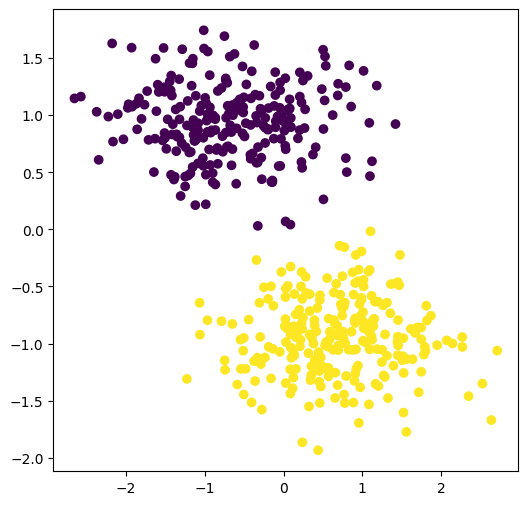

In [2]:
# X as features and Y as labels
X, Y = make_blobs(n_samples=500, centers=2, random_state=0, cluster_std=0.6)
# by default the labels are {0, 1}, so we change them to {-1,1}
Y = np.where(Y==0, -1, 1)

# we also center the input data (per dimension) and scale it to unit variance to make trainig more efficient
X = (X - X.mean(axis=0))/X.std(axis=0)

plt.figure(figsize=(6, 6))
plt.scatter(x=X[:, 0], y=X[:, 1], c=Y)

## Sequential Minimal Optimization (SMO)

This algorithm was originally developed by [John Platt in 1998](http://research.microsoft.com/pubs/69644/tr-98-14.pdf) and is optimized for SVM optimization. This algorithm solves the dual problem in a gradient-free manner. It selects two multiplier $\alpha_i$ and $\alpha_j$ and optimizes them while keeping all other $\alpha$'s constant. And then itertively repeats the procedure over all $\alpha$'s. The efficiency lies in the heuristic used for selecting two $\alpha$ values, which is based on information from previous iterations. In the end we obtain a vector of $M$ values for $\alpha$ corresponding to each training data point, for which most of the $\alpha$ values are $0$ and only the non-zero values contribute to the predictions made by the model.

We adapt the implementation of the SMO algorithm from [this](https://jonchar.net/notebooks/SVM/) reference code by Jon Charest.

**Visualization Utils**

In [3]:
def plot_decision_boundary(model, ax, resolution=100, colors=('b', 'k', 'r'), levels=(-1, 0, 1)):
    """Plots the model's decision boundary on the input axes object.
        Range of decision boundary grid is determined by the training data.
        Returns decision boundary grid and axes object (`grid`, `ax`)."""

    # Generate coordinate grid of shape [resolution x resolution]
    # and evaluate the model over the entire space
    xrange = np.linspace(model.X[:, 0].min(), model.X[:, 0].max(), resolution)
    yrange = np.linspace(model.X[:, 1].min(),
                         model.X[:, 1].max(), resolution)
    grid = [[decision_function(model.alphas, model.Y,
                               model.kernel, model.X,
                               np.array([xr, yr]), model.b) for xr in xrange] for yr in yrange]
    grid = np.array(grid).reshape(len(xrange), len(yrange))

    # Plot decision contours using grid and
    # make a scatter plot of training data
    ax.contour(xrange, yrange, grid, levels=levels, linewidths=(1, 1, 1),
               linestyles=('--', '-', '--'), colors=colors)
    ax.scatter(model.X[:, 0], model.X[:, 1],
               c=model.Y, cmap=plt.cm.viridis, lw=0, alpha=0.25)

    # Plot support vectors (non-zero alphas)
    # as circled points (linewidth > 0)
    mask = np.round(model.alphas, decimals=2) != 0.0
    ax.scatter(model.X[mask, 0], model.X[mask, 1],
               c=model.Y[mask], cmap=plt.cm.viridis, lw=1, edgecolors='k')

    return grid, ax


As a first step, we define a generic SMO model

In [4]:
class SMOModel:
    """Container object for the model used for sequential minimal optimization."""

    def __init__(self, X, Y, C, kernel, alphas, b, errors):
        self.X = X               # training data vector
        self.Y = Y               # class label vector
        self.C = C               # regularization parameter
        self.kernel = kernel     # kernel function
        self.alphas = alphas     # lagrange multiplier vector
        self.b = b               # scalar bias term
        self.errors = errors     # error cache used for selection of alphas
        self._obj = []           # record of objective function value
        self.m = len(self.X)     # store size of training set

The next thing we need to define is the kernel. We start with the simplest linear kernel 

$$K(x,x') = x^{\top} x' + b.$$

The implementation of the radial basis function

$$K(x,x') = \exp \left\{ - \gamma ||x-x'||_2^2 \right\} $$

is also provided for comparison.

In [5]:
def linear_kernel(x, y, b=1):
    """Returns the linear combination of arrays `x` and `y` with
    the optional bias term `b` (set to 1 by default)."""

    return x @ y.T + b  # Note the @ operator for matrix multiplication

def gaussian_kernel(x, y, gamma=1):
    """Returns the gaussian similarity of arrays `x` and `y` with
    kernel inverse width parameter `gamma` (set to 1 by default)."""
    
    ######################
    # TODO: you might find this helpful: https://jonchar.net/notebooks/SVM/
    
    if np.ndim(x) == 1 and np.ndim(y) == 1:
        result = np.exp(- gamma * (np.linalg.norm(x - y, 2)) ** 2)
    elif (np.ndim(x) > 1 and np.ndim(y) == 1) or (np.ndim(x) == 1 and np.ndim(y) > 1):
        result = np.exp(- gamma * (np.linalg.norm(x - y, 2, axis=1) ** 2))
    elif np.ndim(x) > 1 and np.ndim(y) > 1:
        result = np.exp(- gamma * (np.linalg.norm(x[:, np.newaxis] -
                        y[np.newaxis, :], 2, axis=2) ** 2))
    return result
    #######################

Now, using the dual problem formulation and a `kernel`, we define the objective and decision functions.
The decision function simply imlements $(\omega x + b)$ by using the kernel trick and the relation $w=\sum_{i=1}^{m} \alpha_{i} y^{(i)} x^{(i)}$

In [6]:
# Objective function to optimize, i.e. loss function

def objective_function(alphas, target, kernel, X_train):
    """Returns the SVM objective function based in the input model defined by:
    `alphas`: vector of Lagrange multipliers
    `target`: vector of class labels (-1 or 1) for training data
    `kernel`: kernel function
    `X_train`: training data for model."""

    return np.sum(alphas) - 0.5 * np.sum((target[:, None] * target[None, :]) * kernel(X_train, X_train) * (alphas[:, None] * alphas[None, :]))


# Decision function, i.e. forward model evaluation

def decision_function(alphas, target, kernel, X_train, x_test, b):
    """Applies the SVM decision function to the input feature vectors in `x_test`."""

    result = (alphas * target) @ kernel(X_train, x_test) - b
    return result


**The SMO algorithm**

We are now ready to implement the SMO algorithm as given in Platt's paper. The implementation is split into three functions: `take_step`, `examine_example`, and `train`.
- `train` is the main training loop and also implements the selection of the first of the two $\alpha$ values.
- `examine_example` implements the selection of the second $\alpha$ value
- `take_step` optimizes the two $\alpha$ values, the bias $b$, and the cache.

In [7]:
def take_step(i1, i2, model):

    # Skip if chosen alphas are the same
    if i1 == i2:
        return 0, model

    alph1 = model.alphas[i1]
    alph2 = model.alphas[i2]
    y1 = model.Y[i1]
    y2 = model.Y[i2]
    E1 = model.errors[i1]
    E2 = model.errors[i2]
    s = y1 * y2

    # Compute L & H, the bounds on new possible alpha values
    if (y1 != y2):
        L = max(0, alph2 - alph1)
        H = min(model.C, model.C + alph2 - alph1)
    elif (y1 == y2):
        L = max(0, alph1 + alph2 - model.C)
        H = min(model.C, alph1 + alph2)
    if (L == H):
        return 0, model

    # Compute kernel & 2nd derivative eta
    k11 = model.kernel(model.X[i1], model.X[i1])
    k12 = model.kernel(model.X[i1], model.X[i2])
    k22 = model.kernel(model.X[i2], model.X[i2])
    eta = 2 * k12 - k11 - k22

    # Compute new alpha 2 (a2) if eta is negative
    if (eta < 0):
        a2 = alph2 - y2 * (E1 - E2) / eta
        # Clip a2 based on bounds L & H
        if L < a2 < H:
            a2 = a2
        elif (a2 <= L):
            a2 = L
        elif (a2 >= H):
            a2 = H

    # If eta is non-negative, move new a2 to bound with greater objective function value
    else:
        alphas_adj = model.alphas.copy()
        alphas_adj[i2] = L
        # objective function output with a2 = L
        Lobj = objective_function(alphas_adj, model.Y, model.kernel, model.X)
        alphas_adj[i2] = H
        # objective function output with a2 = H
        Hobj = objective_function(alphas_adj, model.Y, model.kernel, model.X)
        if Lobj > (Hobj + eps):
            a2 = L
        elif Lobj < (Hobj - eps):
            a2 = H
        else:
            a2 = alph2

    # Push a2 to 0 or C if very close
    if a2 < 1e-8:
        a2 = 0.0
    elif a2 > (model.C - 1e-8):
        a2 = model.C

    # If examples can't be optimized within epsilon (eps), skip this pair
    if (np.abs(a2 - alph2) < eps * (a2 + alph2 + eps)):
        return 0, model

    # Calculate new alpha 1 (a1)
    a1 = alph1 + s * (alph2 - a2)

    # Update threshold b to reflect newly calculated alphas
    # Calculate both possible thresholds
    b1 = E1 + y1 * (a1 - alph1) * k11 + y2 * (a2 - alph2) * k12 + model.b
    b2 = E2 + y1 * (a1 - alph1) * k12 + y2 * (a2 - alph2) * k22 + model.b

    # Set new threshold based on if a1 or a2 is bound by L and/or H
    if 0 < a1 and a1 < C:
        b_new = b1
    elif 0 < a2 and a2 < C:
        b_new = b2
    # Average thresholds if both are bound
    else:
        b_new = (b1 + b2) * 0.5

    # Update model object with new alphas & threshold
    model.alphas[i1] = a1
    model.alphas[i2] = a2

    # Update error cache
    # Error cache for optimized alphas is set to 0 if they're unbound
    for index, alph in zip([i1, i2], [a1, a2]):
        if 0.0 < alph < model.C:
            model.errors[index] = 0.0

    # Set non-optimized errors based on equation 12.11 in Platt's book
    non_opt = [n for n in range(model.m) if (n != i1 and n != i2)]
    model.errors[non_opt] = model.errors[non_opt] + \
        y1*(a1 - alph1)*model.kernel(model.X[i1], model.X[non_opt]) + \
        y2*(a2 - alph2) * \
        model.kernel(model.X[i2], model.X[non_opt]) + model.b - b_new

    # Update model threshold
    model.b = b_new

    return 1, model


In [8]:
def examine_example(i2, model):

    y2 = model.Y[i2]
    alph2 = model.alphas[i2]
    E2 = model.errors[i2]
    r2 = E2 * y2

    # Proceed if error is within specified tolerance (tol)
    if ((r2 < -tol and alph2 < model.C) or (r2 > tol and alph2 > 0)):

        if len(model.alphas[(model.alphas != 0) & (model.alphas != model.C)]) > 1:
            # Use 2nd choice heuristic is choose max difference in error
            if model.errors[i2] > 0:
                i1 = np.argmin(model.errors)
            elif model.errors[i2] <= 0:
                i1 = np.argmax(model.errors)
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model

        # Loop through non-zero and non-C alphas, starting at a random point
        for i1 in np.roll(np.where((model.alphas != 0) & (model.alphas != model.C))[0],
                          np.random.choice(np.arange(model.m))):
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model

        # loop through all alphas, starting at a random point
        for i1 in np.roll(np.arange(model.m), np.random.choice(np.arange(model.m))):
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model

    return 0, model


In [9]:
def train(model):

    numChanged = 0
    examineAll = 1 # loop over each alpha in first round

    while (numChanged > 0) or (examineAll):
        numChanged = 0
        if examineAll:
            # loop over all training examples
            for i in range(model.alphas.shape[0]):
                examine_result, model = examine_example(i, model)
                numChanged += examine_result
                if examine_result:
                    obj_result = objective_function(
                        model.alphas, model.Y, model.kernel, model.X)
                    model._obj.append(obj_result)
        else:
            # loop over examples where alphas are not already at their limits
            for i in np.where((model.alphas != 0) & (model.alphas != model.C))[0]:
                examine_result, model = examine_example(i, model)
                numChanged += examine_result
                if examine_result:
                    obj_result = objective_function(
                        model.alphas, model.Y, model.kernel, model.X)
                    model._obj.append(obj_result)
        if examineAll == 1:
            examineAll = 0
        elif numChanged == 0:
            examineAll = 1

    return model


We are now ready to define the model (after defining some hyperparameters).

In [15]:
# Set model parameters and initial values
C = 10
m = len(X)
initial_alphas = np.zeros(m)
initial_b = 0.0

# Set tolerances
tol = 0.01  # error tolerance
eps = 0.01  # alpha tolerance

# Instantiate model
model = SMOModel(
    X, Y, C, 
    kernel=gaussian_kernel, # TODO: try linear_kernel and  gaussian_kernel
    alphas=initial_alphas,
    b=initial_b,
    errors= np.zeros(m)
)

# Initialize error cache
initial_error = decision_function(model.alphas, model.Y, model.kernel,
                                  model.X, model.X, model.b) - model.Y
model.errors = initial_error

In [16]:
np.random.seed(0)
output = train(model)

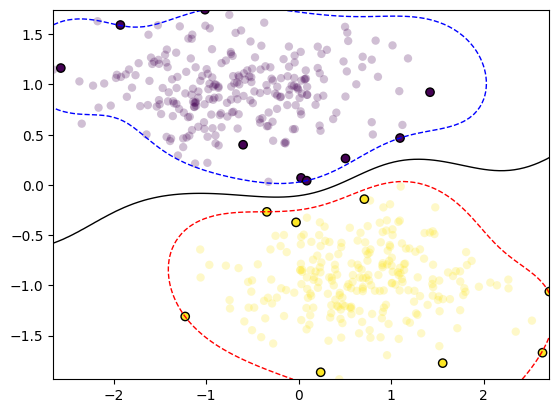

In [17]:
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output, ax)

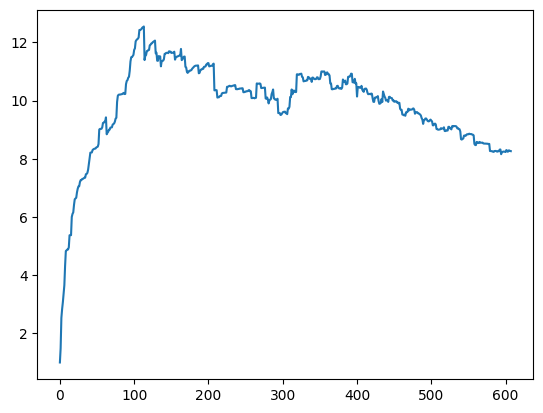

In [18]:
# loss curve
# note: we started with all alphas = 0 and turned some of them on one by one, and then refined.

plt.plot(model._obj)

## Multiclass Classification with SVM and SMO

We look at a problem we have seen before: the classification of the iris dataset. The task is to use two of the measured input features ("sepal_length" and "sepal_width") and to build a classifier capable of distinguishing among the three possible flowers, which we index by [0, 1, 2].

Getting the data is equivalent to the process we saw in exercise on [Linear and Logistic Regression](./linear.ipynb) in the Logistic Regression section.

In [19]:
# get iris dataset
from urllib.request import urlretrieve
iris = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
urlretrieve(iris)
df0 = pd.read_csv(iris, sep=',')

# name columns
attributes = ["sepal_length", "sepal_width",
              "petal_length", "petal_width", "class"]
df0.columns = attributes

# add species index
species = list(df0["class"].unique())
df0["class_idx"] = df0["class"].apply(species.index)

print("Count occurence of each class:")
print(df0["class"].value_counts())

# let's extract two of the features, and the indexed classes [0,1,2]
df = df0[["petal_length", "petal_width", "class_idx"]]

X_train = df[['petal_length', 'petal_width']].to_numpy()
Y_train = df['class_idx'].to_numpy()
print("Training data:")
print(df)


Count occurence of each class:
class
Iris-versicolor    50
Iris-virginica     50
Iris-setosa        49
Name: count, dtype: int64
Training data:
     petal_length  petal_width  class_idx
0             1.4          0.2          0
1             1.3          0.2          0
2             1.5          0.2          0
3             1.4          0.2          0
4             1.7          0.4          0
..            ...          ...        ...
144           5.2          2.3          2
145           5.0          1.9          2
146           5.2          2.0          2
147           5.4          2.3          2
148           5.1          1.8          2

[149 rows x 3 columns]


**Exercise**

Now, implement a SVM-based multi-class classifier, which can be trained using the SMO algorithm. Compare with the solution presented below.

Hint: [this](https://github.com/itsikad/svm-smo) repository and the one-vs-all classifier.

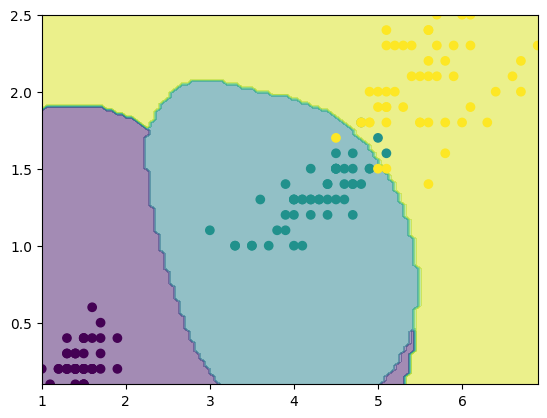

In [21]:
####################

class OneVsAll:

    def __init__(self, solver, num_classes, **kwargs):
        self._binary_clf = [solver(i, **kwargs) for i in range(num_classes)]
        self._num_classes = num_classes

    def predict(self, x):
        n = x.shape[0]
        scores = np.zeros((n, self._num_classes))

        for idx in range(self._num_classes):
            model = self._binary_clf[idx]
            scores[:, idx] = decision_function(
                model.alphas,
                model.Y,
                model.kernel,
                model.X,
                x,
                model.b)

        pred = np.argmax(scores, axis=1)
        return pred

    def fit(self):
        np.random.seed(0)

        for idx in range(self._num_classes):
            self._binary_clf[idx] = train(
                self._binary_clf[idx])  # fit(x_train, y_tmp)


def create_binary_clf(class_idx, C, X, Y, kernel):
    # Set model parameters and initial values
    C = 10.
    m = len(X)
    initial_alphas = np.zeros(m)
    initial_b = 0.0

    # Set tolerances
    tol = 0.01  # error tolerance
    eps = 0.01  # alpha tolerance

    Y_tmp = 1. * (Y == class_idx) - 1. * (Y != class_idx)

    # Instantiate model
    model = SMOModel(
        X, Y_tmp, C,
        kernel=kernel,
        alphas=initial_alphas,
        b=initial_b,
        errors=np.zeros(m)
    )

    # Initialize error cache
    initial_error = decision_function(model.alphas, model.Y, model.kernel,
                                      model.X, model.X, model.b) - model.Y
    model.errors = initial_error

    return model


def plot_decision_boundary_multiclass(solver, ax, Y, resolution=100):
    """Plots the model's decision boundary on the input axes object.
        Range of decision boundary grid is determined by the training data.
        Returns decision boundary grid and axes object (`grid`, `ax`)."""

    # Generate coordinate grid of shape [resolution x resolution]
    # and evaluate the model over the entire space
    model0 = solver._binary_clf[0]
    xrange = np.linspace(model0.X[:, 0].min(),
                         model0.X[:, 0].max(), resolution)
    yrange = np.linspace(model0.X[:, 1].min(),
                         model0.X[:, 1].max(), resolution)
    x, y = np.meshgrid(xrange, yrange)
    xy = np.array(list(map(np.ravel, [x, y]))).T  # shape=(num_samples, dim)
    grid = solver.predict(xy)
    grid = np.array(grid).reshape(len(xrange), len(yrange))

    # Plot decision contours using grid and
    # make a scatter plot of training data
    ax.contourf(xrange, yrange, grid, alpha=0.5)
    ax.scatter(model0.X[:, 0], model0.X[:, 1], c=Y)

    return grid, ax


solver = OneVsAll(
    solver=create_binary_clf,
    num_classes=3,
    C=1.,
    X=X_train,
    Y=Y_train,
    kernel=gaussian_kernel  # linear_kernel vs gaussian kernel
)

solver.fit()

fig, ax = plt.subplots()
grid, ax = plot_decision_boundary_multiclass(solver, ax, Y_train)
plt.show()


####################

## Gradient Descent Optimization of Soft Margin Classifier

We can also directly solve the primal problem with gradient-based optimization, if we slightly reformulate it. This reformulation requires using the [hinge loss](https://en.wikipedia.org/wiki/Hinge_loss):

$$\mathcal{L}_{hinge}(x) = \max(0, 1-x)$$

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Hinge_loss_vs_zero_one_loss.svg/1280px-Hinge_loss_vs_zero_one_loss.svg.png" alt="drawing" width="500"/>

What we would give as an input to the hinge loss is the "raw" output of the classifier, e.g. for linear SVMs $out= \omega x + b$, multiplied with the correct output $y$. Thus, the hinge loss of a single sample $i$ for a linear SVM becomes

$$\mathcal{L}_i = \max \left( 0, \; 1 - y^{(i)}(\omega^{\top} x^{(i)} + b) \right).$$

To fully recover the Soft Margin Classifier, we simply add the squared L2 regularization to this loss, thus the total loss becomes

$$\mathcal{L} = \frac{1}{M}\sum_{i=1}^M \max \left( 0, \; 1 - y^{(i)}(\omega^{\top} x^{(i)} + b) \right) + \lambda ||w||_2^2.$$

Here, the parameter $\lambda$ controls the amount of shrinkage applied to the coefficients to mitigate overfitting. This is fundamentally different from the $C$ in the Soft Margin Classifier formalism, which is also a regularization parameter, but it influences the trade off between the margin size and the training error.

If we want to do something like kernels (although there is no dot product here), the best we can do is directly applying the input feature transformation $x \to \varphi(x)$ which leads to the loss

$$\mathcal{L} = \frac{1}{M}\sum_{i=1}^M \max \left( 0, \; 1 - y^{(i)}(\omega^{\top} \varphi(x^{(i)}) + b) \right) + \lambda ||w||_2^2.$$

However, as you might remember, there is no practically useful $\varphi$ corresponding to the RBF kernel - there is one, but it is [an infinitely long sum](https://stats.stackexchange.com/questions/123413/using-a-gaussian-kernel-in-svm-how-exactly-is-this-then-written-as-a-dot-produc). Thus, the hinge loss approach is somewhat restrictive.

Note: there is a similar loss function corresponding to the logistic regression. See [this](https://en.wikipedia.org/wiki/Support_vector_machine#SVM_and_the_hinge_loss) for more details. 


**Visualization Utils**

In [23]:
def visualize_torch(X, Y, model, linear=False):
    """
    based on 
    https://scikit-learn.org/stable/auto_examples/svm/plot_svm_margin.html#sphx-glr-auto-examples-svm-plot-svm-margin-py
    """

    plt.figure(figsize=(6, 6))
    plt.scatter(x=X[:, 0], y=X[:, 1], c=Y, s=10)

    w = model.linear.weight.squeeze().detach().numpy()
    b = model.linear.bias.squeeze().detach().numpy()
    
    delta = 0.02

    if linear:

        # extend bounds by "delta" to improve the plot
        x_min = X[:, 0].min() - delta
        x_max = X[:, 0].max() + delta

        # solving $w0+x1 + w1*x2 + b = 0$ for $x2$ leads to $x2 = -w0/w1 - b/w1$
        a = -w[0] / w[1]
        xx = np.linspace(x_min, x_max, 50)
        yy = a * xx - b / w[1]

        # $margin = 1 / ||w||_2$
        # Why? Recall that the distance between a point (x_p, y_P) and a line
        # $ax+by+c=0$ is given by $|ax_p+by_p+c|/\sqrt{a^2+b^2}$. As we set the
        # functional margin to 1, i.e. $|ax_i+by_i+c|=1$ for a support vector
        # point, then the total margin becomes $1 / ||w||_2$.
        margin = 1 / np.sqrt(np.sum(w**2))
        yy_up = yy + np.sqrt(1+a**2) * margin
        yy_down = yy - np.sqrt(1+a**2) * margin

        plt.plot(xx, yy, "r-")
        plt.plot(xx, yy_up, "r--")
        plt.plot(xx, yy_down, "r--")
        
    else:
        x = np.arange(X[:, 0].min(), X[:, 0].max(), delta)
        y = np.arange(X[:, 1].min(), X[:, 1].max(), delta)
        x, y = np.meshgrid(x, y)
        xy = list(map(np.ravel, [x, y]))
        xy = torch.tensor(xy, dtype=torch.float32).T
        z = model(xy)
        z = z.detach().numpy().reshape(x.shape)
        
        cs0 = plt.contourf(x, y, z, alpha=0.6)
        plt.contour(cs0, '-', levels=[0], colors='r', linewidth=5)
        plt.plot(np.nan, label='decision boundary', color='r')
        plt.legend()
        
    plt.grid()
    plt.xlim([X[:, 0].min() + delta, X[:, 0].max() - delta])
    plt.ylim([X[:, 1].min() + delta, X[:, 1].max() - delta])
    plt.tight_layout()
    plt.show()


Let's first define a base SVM class, a linear kernel, the hinge loss, and the regularization over weights.

In [24]:
class SupportVectorMachine(nn.Module):

    def __init__(self, input_size, phi):
        super().__init__()
        # X_train.shape should be (num_samples, dim x)
        self.input_size = input_size
        self.phi = phi
        self.linear = nn.Linear(self.input_size, 1)

    def forward(self, x):
        phi_x = self.phi(x)
        out = self.linear(phi_x)
        return out


class PhiLinear(nn.Module):
    
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x
    

def hinge_loss(y, out):
    """Hinge loss"""
    return torch.mean(torch.clamp(1 - y * out, min=0))


def sq_l2_reg(model):
    """Squared L2 regularization of weights"""
    return model.linear.weight.square().sum()


**Exercise**

Implement the Radial Basis Function kernel. After that, use your new kernel implementation to run a training process and visualize results.

Hint: [this](https://gist.github.com/mlaves/c98cd4e6bcb9dbd4d0c03b34bacb0f65) reference.

In [25]:
class PhiRBF(nn.Module):
    """Something like a Radial Basis Function feature map
    Lifts the dimension from X.shape[-1] to X.shape[0]"""

    def __init__(self, X_train, gamma):
        super().__init__()
        self.X_train = X_train
        self.gamma = gamma
        
    def forward(self, x):
        ##############################
        # TODO: implement the forward methods
        # The choice of this specific phi is arbitrary and is not the true RBF.
        # We lift the input space from the space of `x` to a space of 
        # dimension equal to the number of training data points.
        out = self.X_train.repeat(x.size(0), 1, 1)
        out = torch.exp(-self.gamma * ((x[:, None] - out) ** 2).sum(dim=2))
        return out
        ##############################

Some preparation before we train the model

In [26]:
# prepare the data
X = torch.Tensor(X)
Y = torch.Tensor(Y)
N = len(Y)

In [34]:
torch.manual_seed(42)

# set hyperparameters
learning_rate = 0.1
epochs = 1000
batch_size = 100
reg_lambda = 0.001
phi_type = 'rbf'  # TODO: try both "lin" and "rbf"

if phi_type == 'lin':
  phi = PhiLinear() 
  input_size = X.shape[1]
elif phi_type == 'rbf':
  phi = PhiRBF(X_train=X, gamma=1.0) 
  input_size = X.shape[0]
  
# initialize model
model = SupportVectorMachine(input_size, phi) 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model.train()

# print initial parameters
for name, param in model.named_parameters():
  print(name, ": ", param.data)


linear.weight :  tensor([[ 0.0342,  0.0371, -0.0105,  0.0411, -0.0098,  0.0090, -0.0218,  0.0263,
          0.0394, -0.0328,  0.0389,  0.0084,  0.0330,  0.0061,  0.0216, -0.0063,
          0.0345,  0.0066, -0.0209,  0.0114, -0.0206, -0.0052, -0.0182,  0.0297,
         -0.0353, -0.0206, -0.0126, -0.0269,  0.0042, -0.0442,  0.0404, -0.0380,
          0.0345,  0.0074, -0.0145,  0.0276,  0.0070,  0.0361,  0.0049, -0.0141,
          0.0120, -0.0121,  0.0188,  0.0399,  0.0259, -0.0196,  0.0258,  0.0080,
          0.0227, -0.0273, -0.0443, -0.0173, -0.0343,  0.0367,  0.0129,  0.0185,
          0.0141, -0.0008,  0.0350, -0.0318,  0.0028, -0.0305,  0.0138, -0.0154,
          0.0137, -0.0093,  0.0371, -0.0265, -0.0267, -0.0267,  0.0402,  0.0149,
          0.0430, -0.0369, -0.0444, -0.0350, -0.0301,  0.0181,  0.0160,  0.0372,
         -0.0231, -0.0305,  0.0237, -0.0181,  0.0271, -0.0106,  0.0256, -0.0347,
         -0.0226,  0.0136,  0.0095, -0.0114,  0.0267,  0.0304, -0.0324, -0.0239,
          0

Now, we can train the model.

We iterate over the data by following these two steps in each epoch:
1. randomly permute all indices up to the number of training data points at each epoch.
2. iterate over all batches by picking the samples corresponding to the current subset of indices

In [ ]:
for epoch in range(epochs):
    random_nums = torch.randperm(N)

    # Iterate over the individual batches
    for i in range(0, N, batch_size):
        x = X[random_nums[i:i + batch_size]]
        y = Y[random_nums[i:i + batch_size]]

        optimizer.zero_grad()
        output = model(x)

        loss = hinge_loss(y.unsqueeze(1), output) + \
            reg_lambda * sq_l2_reg(model)
        loss.backward()
        optimizer.step()

    print('epoch {}, loss {}'.format(epoch, loss.item()))


In [36]:
# print final parameters
for name, param in model.named_parameters():
  print(name, ": ", param.data)


linear.weight :  tensor([[-4.3840e-02,  3.7154e-02, -1.8599e-02, -2.9914e-01,  4.8049e-02,
         -3.8624e-02, -5.9737e-02, -1.8046e-02,  4.8639e-02, -3.7677e-01,
         -3.0616e-02, -5.9867e-02, -1.8603e-02,  3.0316e-01, -7.6967e-02,
          4.9941e-02, -1.4472e-02,  1.8021e-01,  6.9080e-02,  5.5923e-03,
         -2.4834e-02,  4.9265e-02,  6.8726e-02, -3.2119e-02,  6.5568e-02,
          1.5987e-01, -5.7546e-02,  9.1915e-02, -4.9658e-02, -8.7284e-03,
          8.8835e-02, -2.8591e-02,  1.1857e-02, -2.7662e-02, -1.0790e-01,
         -5.4270e-02,  7.3896e-02,  1.1921e-02, -1.4514e-02,  1.0379e-01,
         -4.4070e-02, -4.4913e-02,  7.5571e-02, -1.0362e-01,  7.2744e-02,
         -3.9317e-02,  4.8648e-02,  8.9887e-02, -1.8805e-01, -1.3462e-03,
         -2.0104e-03, -3.6487e-01, -5.4353e-02,  3.8214e-02, -1.5799e-02,
         -4.9141e-02, -1.4759e-02, -5.6240e-02, -4.1308e-02, -1.2092e-01,
          5.7895e-02,  8.9047e-02, -3.6861e-02, -3.1655e-01,  5.3951e-02,
          7.2144e-02,

In this formulation all samples are used to fit the parameters. This in contranst to the SMO solution might take longer to optimize, but is more stable because we don't select individial samples and ignore all the others.

/tmp/ipykernel_10392/3784346825.py:49: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(cs0, '-', levels=[0], colors='r', linewidth=5)


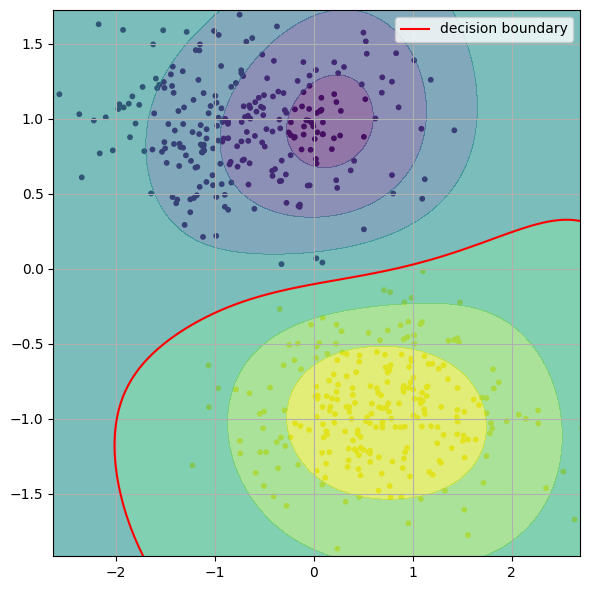

In [37]:
visualize_torch(X, Y, model=model)